# Searchflow

### Packages needed to run this notebook
- libmagic: ```brew install libmagic```

### ChromaDB
Don't forget to start the ChromaDB server: ```docker run -p 7777:8000 chromadb/chroma```

### Run the API
https://docs.astral.sh/uv/guides/integration/fastapi/

For development purposes, you can run the API with: ```uv run fastapi dev```

In [1]:
# Load packages from the src directory
import sys
import json
sys.path.append('../src')
from vectrix_graphs import ExtractDocuments, setup_logger, ExtractMetaData


from dotenv import load_dotenv
load_dotenv()

2024-10-27 15:44:37,909 - VectorDB - WARNING - Connecting to ChromaDB on localhost failed, using hosted service instead
2024-10-27 15:44:38,593 - VectorDB - WARNING - Demo collection already exists


True

### Extracting chunks of data from a document

In [3]:
# Create chunks of data from a document
extract = ExtractDocuments(
    logger=setup_logger(name="Files", level="INFO"),
    )

result = extract.extract(file_path="./files/arabic_test.docx")


2024-10-27 15:44:58,525 - Files - INFO - Extracting documents from ./files/arabic_test.docx


In [4]:
print('Metadata:')
print(json.dumps(result[1].metadata, indent=4))

print('Content:')
print(result[1].page_content)

Metadata:
{
    "file_directory": "./files",
    "filename": "arabic_test.docx",
    "last_modified": "2024-10-25T10:09:47",
    "orig_elements": "eJzdWNtu3DYQ/RVhnxKgdHkZ3vwHAYI++a0pjBEv7QK+BGu1SBD03ystudjR0oploG12/UII5JAcHp4zw9Gv3zbpLt2nh+F2GzfX3cYmiS7GzELqLQOrHPMoFDMQslJJRe/M5qduc58GjDjgOOfbJuCQfn/cfb2N6fPwx9jFR4u8vUu3cbtLYRiHprWvfp76njZ18AHv09SNO+y34XZIT8NVfAxfpvE7fBpu7x/jNm/T3i/JJTDBmdQ3gl9zfw128/doOKQvwzT+6U9upJ1agH2r9z1x3+K+x+1bPFpKnLYavn7eu3GzHe7StOYpJJEHtOgsU04nBhyQOdTAsoIc+sAt7+VFQGKmVlnSL7sjMtS0IFZNCW4gKWIft0/DhyHdPwvaSJSsrWRCZs5AecMc6DBimJL0FqJW6mxBK9wJewwE4Qv9xo4A5QnKSJAtwzITfAua0DWQq+Mw3fSwUstte7qp9Eummawaiunqi0wxKGuRRQVjQIjRMae9YAmENjHZiCOCL16k+DEXqSjkBJv++sJvryPKNJShXXOiYquos25hJzXbby1DeuTItZdMKTdKPUdgzqFgPnKnENzowoqU8YMY0hMkzGmCeCM8qY4XnmTSVWaA7o7jCsoiqxjSkQEKjjv1v2Zg+4pDrmWfDz2YqPLIvmym7MyZn1K0VdxJkCCExYtgHzQ9b5Z99UTmOBsMGQB5XKrsOqcaTcMlSbdOlZefUsSUvHJq9q4rFVSwYXOxLUaqOlgRpPtp4jmJxWp+/DJDE0/IjclWb3PfVmdrFIKHPjJMHhhI7JlPSrNggnMZdQwjO89UDbN7dafX8HbVQGPqwZvuVAcHLranCKe0X

In [5]:
# Add additional metadata using a NER-pipeline
ner = ExtractMetaData(
    logger=setup_logger(name="ExtractMetaData", level="INFO",),
    model="gpt-4o-mini" # Options are gpt-4o-mini, llama3.1-8B , llama3.1-70B
    )
result_with_metadata = ner.extract(result, source="uploaded_file")

2024-10-27 15:45:07,454 - ExtractMetaData - INFO - Extracting metadata from 9 documents, using gpt-4o-mini


In [6]:
result_with_metadata[0].metadata

{'filename': 'arabic_test.docx',
 'filetype': 'application/vnd.openxmlformats-officedocument.wordprocessingml.document',
 'author': 'هيئة السوق المالية',
 'source': 'uploaded_file',
 'word_count': 41,
 'language': 'AR',
 'content_type': 'other',
 'tags': "['Finance', 'Stock Market', 'Saudi Arabia']",
 'summary': 'The document outlines the procedures for suspending the trading of listed securities according to the listing rules approved by the Capital Market Authority in Saudi Arabia.',
 'read_time': 0.205,
 'last_modified': '2024-10-25T10:09:47'}

### Adding the documents to a vector database (Chroma)

For this demo, the vector database will be saved locally on disk, restarting the container will delete the database.
I prefer using the cosine distance instead of the default squared L2 distance, we pass this using the `hnsw:space` metadata.

$$
d = 1.0 - \frac{\sum(A_i \times B_i)}{\sqrt{\sum(A_i^2) \cdot \sum(B_i^2)}}
$$

We use Ollama to calculate the embeddings locally with BGE-M3, since over a 100 langues are supported this is ideal for embedding Arabic documents.

BGE-M3 is based on the XLM-RoBERTa architecture and is distinguished for its versatility in Multi-Functionality, Multi-Linguality, and Multi-Granularity:

- Multi-Functionality: It can simultaneously perform the three common retrieval functionalities of embedding model: dense retrieval, multi-vector retrieval, and sparse retrieval.
- Multi-Linguality: It can support more than 100 working languages.
- Multi-Granularity: It is able to process inputs of different granularities, spanning from short sentences to long documents of up to 8192 tokens.

> ℹ️ So all embeddings will be calculated locally ℹ️


In [2]:
from vectrix_graphs import vectordb

vectordb.remove_collection("demo")
vectordb.create_collection("demo")

In [7]:
vectordb.add_documents(result_with_metadata)

In [9]:
from vectrix_graphs import vectordb
# Now let's query the vector database
vectordb.similarity_search(
    query=" ماهي الإجراءات المتبعة عند صدور قرار الجمعية العامة غير العادية بتخفيض رأس مال المصدر؟",
    k=3
    )

[Document(metadata={'author': '', 'content_type': 'other', 'filename': 'arabic_test.docx', 'filetype': 'application/vnd.openxmlformats-officedocument.wordprocessingml.document', 'language': 'AR', 'last_modified': '2024-10-25T10:09:47', 'read_time': 0.33, 'source': 'uploaded_file', 'summary': 'يتعلق النص بإجراءات تخفيض رأس المال من قبل الجمعية العامة غير العادية للمصدر، مع التأكيد على عدم الإخلال بالأحكام واللوائح ذات الصلة.', 'tags': "['الأسواق المالية', 'القرارات', 'اللوائح التنفيذية']", 'word_count': 66, 'cosine_distance': 0.86814846545299, 'uuid': '9eb58317-3714-492f-8abd-0bc551c8e5f8'}, page_content='عند صدور قرار عن الجمعية العامة غير العادية للمصدر بتخفيض رأس ماله وذلك ليومي التداول التاليين لصدور القرار.\nب. لا تخلّ هذه الإجراءات بالأحكام الواردة في نظام السوق المالية ولوائحه التنفيذية وقواعد السوق والأنظمة الأخرى ذات العلاقة.\nج. لا يحول اتخاذ أي إجراء وارد في هذه الإجراءات دون إيقاع الجزاءات المقررة على المصدر في حال خالف أي من أحكام نظام السوق المالية ولوائحه التنفيذية وقواعد

## Asking questions to the Graph
 Let's now ask questions using the LangGraph workflow

### Example 1: Using closed source LLMs


### Example 2: Using open-source LLMs that can be self-hosted

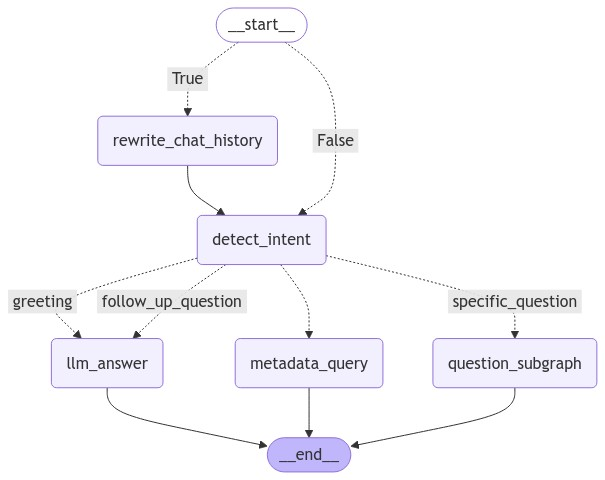

***Question:*** 
  ماهي الإجراءات المتبعة عند صدور قرار الجمعية العامة غير العادية بتخفيض رأس مال المصدر؟



تتضمن الإجراءات المتبعة عند صدور قرار الجمعية العامة غير العادية بتخفيض رأس مال المصدر الخطوات التالية:

1. تعلق السوق تداول الأوراق المالية لجلستي التداول التاليتين لصدور قرار الجمعية العامة غير العادية للمصدر بتخفيض رأس ماله [1].
2. تعلن السوق على موقعها الإلكتروني عن تعليق تداول الأوراق المالية للمصدر [1].
3. ترفع السوق التعليق عن الأوراق المالية مباشرة بعد مرور جلستي تداول تلي صدور قرار الجمعية العامة غير العادية بتخفيض رأس المال [1].

References:
[1] رابعاً: تعليق تداول الأوراق المالية المدرجة عند صدور قرار الجمعية العامة غير العادية للمصدر بتخفيض رأس ماله


In [11]:
# Load packages from the src directory
import sys
from IPython.display import Markdown, display, Image
sys.path.append('../src')

from langchain_core.messages import HumanMessage
from vectrix_graphs import local_slm_demo

# Display the graph
display(Image(local_slm_demo.get_graph().draw_mermaid_png()))

#Ask the question
input = [HumanMessage(content=" ماهي الإجراءات المتبعة عند صدور قرار الجمعية العامة غير العادية بتخفيض رأس مال المصدر؟")]


# Run the graph
response = await local_slm_demo.ainvoke({"messages": input})
display(Markdown(f"***Question:*** \n {input[0].content}\n"))
display(Markdown(response['messages'][-1].content))

In [ ]:
# Load packages from the src directory
import sys
import json
from IPython.display import Markdown, display, Image
sys.path.append('../src')

from langchain_core.messages import HumanMessage
from vectrix_graphs import local_slm_demo

#Ask the question
input = [HumanMessage(content="What is the attention mechanism?")]

response = await local_slm_demo.ainvoke({"messages": input})
print(json.dumps(response, indent=4))

In [ ]:
print(response['messages'][-1])

In [ ]:
from langchain_core.messages import HumanMessage, AIMessage
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate


human = HumanMessage(content="What is the attention mechanism?")
ai = AIMessage(content="The attention mechanism is a technique used in neural networks to enable the model to focus on relevant parts of the input data during processing.")

messages = ChatPromptTemplate.from_messages([human, ai])


llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

chain = messages | llm | StrOutputParser()

chain.invoke({})